**Import needed modules**

In [27]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

from keras.api.preprocessing import image
from keras.api.utils import image_dataset_from_directory
from keras.api.applications.imagenet_utils import preprocess_input


- Configurations for the notebook

In [28]:
# Constants
DATASET_PATH = f'{os.getcwd()}/chicken-diseases/'
DATASET_REMOTE_PATH = 'https://www.kaggle.com/datasets/awathabdat/chicken-diseases'
IMAGE_SIZE = (224, 224)
VALIDATION_SPLIT = 0.2
SHUFFLE_SEED = 123
BATCH_SIZE = 32

# Set the color of the grid for seaborn charts
sns.set_style('darkgrid')

- Download the dataset

In [29]:
od.download(DATASET_REMOTE_PATH)

Skipping, found downloaded files in "./chicken-diseases" (use force=True to force download)


- Read the dataset

**Read the dataset for images.**

In [30]:
train_dataset, validation_dataset = image_dataset_from_directory(
    DATASET_PATH,
    validation_split = VALIDATION_SPLIT,
    shuffle=True,
    seed=SHUFFLE_SEED,
    subset="both",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
)

Found 8067 files belonging to 4 classes.
Using 6454 files for training.
Using 1613 files for validation.


In [31]:
class_names = train_dataset.class_names
print(class_names)

['cocci', 'healthy', 'ncd', 'salmonela']


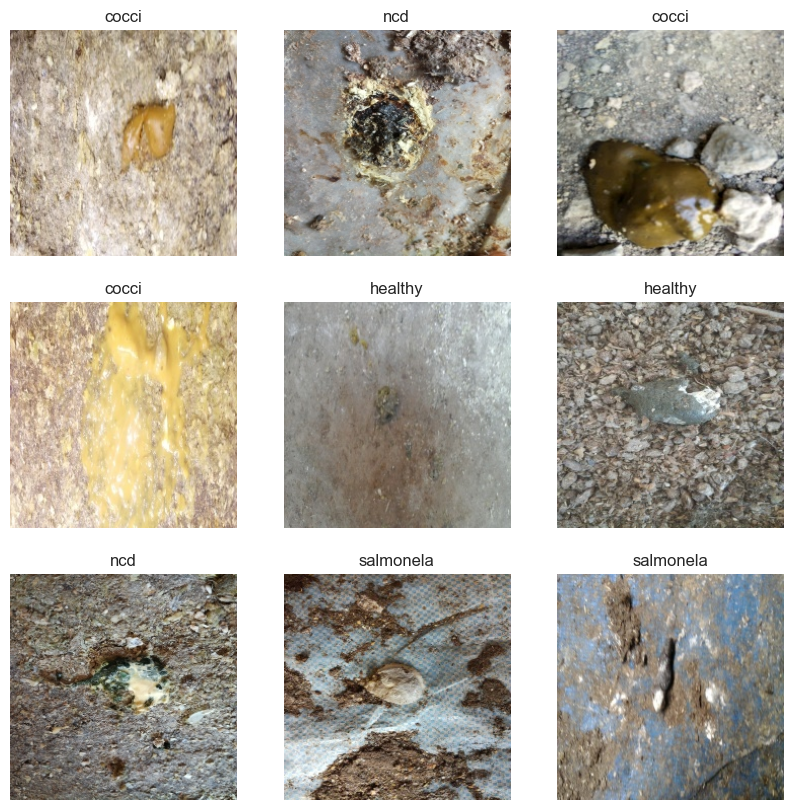

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [33]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [34]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.039215688 1.0


In [35]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [36]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  # loss=f1_weighted,
  metrics=[tf.keras.metrics.F1Score()]
)

In [37]:
model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=9
)

Epoch 1/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 100s 488ms/step - f1_score: 0.4569 - loss: 1.0556 - val_f1_score: 0.6331 - val_loss: 0.5934
Epoch 2/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 102s 505ms/step - f1_score: 0.6246 - loss: 0.6064 - val_f1_score: 0.6525 - val_loss: 0.5091
Epoch 3/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 97s 480ms/step - f1_score: 0.7045 - loss: 0.4969 - val_f1_score: 0.7408 - val_loss: 0.4776
Epoch 4/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 98s 487ms/step - f1_score: 0.7899 - loss: 0.3975 - val_f1_score: 0.8100 - val_loss: 0.4036
Epoch 5/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 102s 506ms/step - f1_score: 0.8436 - loss: 0.3163 - val_f1_score: 0.7947 - val_loss: 0.4737
Epoch 6/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 95s 471ms/step - f1_score: 0.8819 - loss: 0.2579 - val_f1_score: 0.8254 - val_loss: 0.5121
Epoch 7/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 90s 447ms/step - f1_score: 0.9104 - loss: 0.1911 - val_f1_score: 0.8506 - val_loss: 0.4597
Epoch 8/9
202/202 ━━━━━━━━━━━━━━━━━━━━ 93s 462ms/step - f1_score: 0.9265 - loss: 0.1815

In [38]:
img = image.load_img(f"{DATASET_PATH}salmonela/salmo.5.jpg", target_size=(224, 224))
x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
prediction = model.predict(x)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [39]:
# Save the model
model.save("chickens.keras", )